In [1]:
import pyabc

import numpy as np
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 2

def model(parameter):
    u1 = np.array([parameter["U%d1" % i] for i in range(1, N+1)])
    u2 = np.array([parameter["U%d2" % i] for i in range(1, N+1)])
    v1 = np.array([parameter["V%d1" % i] for i in range(1, N+1)])
    v2 = np.array([parameter["V%d2" % i] for i in range(1, N+1)])

    U = np.stack((u1, u2), axis=1)
    V = np.stack((v1, v2), axis=1)

    J = np.matmul(U, np.transpose(V))
    Js = (J + np.transpose(J)) / 2.
    Js_eigs = np.linalg.eigvalsh(Js)
    Js_eig_max = np.max(Js_eigs, axis=0)

    # Take eig of low rank similar mat
    Jr = np.matmul(np.transpose(V), U) + 0.0001*np.eye(2)
    Jr_tr = np.trace(Jr)
    sqrt_term = np.square(Jr_tr) + -4.*np.linalg.det(Jr)
    if sqrt_term < 0.:
        sqrt_term = 0.
    J_eig_realmax = 0.5 * (Jr_tr + np.sqrt(sqrt_term))
    
    return {"data": np.array([J_eig_realmax, Js_eig_max])}

In [3]:
parameters = [("U%d1" % i,  pyabc.RV("uniform", -1., 1.)) for i in range(1, N+1)]
parameters += [("U%d2" % i, pyabc.RV("uniform", -1., 1.)) for i in range(1, N+1)]
parameters += [("V%d1" % i, pyabc.RV("uniform", -1., 1.)) for i in range(1, N+1)]
parameters += [("V%d2" % i, pyabc.RV("uniform", -1., 1.)) for i in range(1, N+1)]
parameters = dict(parameters)

In [4]:
prior = pyabc.Distribution(parameters)

In [5]:
def distance(x, y):
    return np.linalg.norm(x["data"] - y["data"])

In [6]:
sampler = pyabc.sampler.SingleCoreSampler()
abc = pyabc.ABCSMC(model, prior, distance, sampler=sampler)

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observation = np.array([0.5, 1.5])
abc.new(db_path, {"data": observation})

INFO:History:Start <ABCSMC(id=3, start_time=2020-09-23 18:17:09.476900, end_time=None)>


In [8]:
history = abc.run(minimum_epsilon=1./np.sqrt(2.), max_nr_populations=10)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.8180341246887238
INFO:ABC:t: 0, eps: 0.8180341246887238.
INFO:ABC:Acceptance rate: 100 / 184 = 5.4348e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7168477923370031.
INFO:ABC:Acceptance rate: 100 / 211 = 4.7393e-01, ESS=1.4706e+01.
INFO:ABC:t: 2, eps: 0.6774838738185741.
INFO:ABC:Acceptance rate: 100 / 385 = 2.5974e-01, ESS=2.0389e+01.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=3, start_time=2020-09-23 18:17:09.476900, end_time=2020-09-23 18:17:13.999422)>


In [9]:
df1, w = history.get_distribution(m=0,t=history.max_t)

In [11]:
print(history.total_nr_simulations)

880


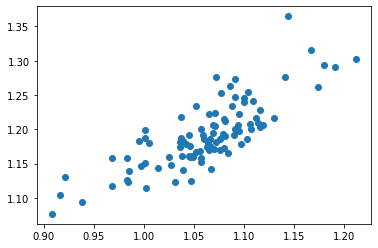

In [11]:
def T(z):
    M = z.shape[0]
    T_z = np.zeros((M,2))
    for m in range(M):
   
        u1 = z[m,:N]
        u2 = z[m,N:(2*N)]
        v1 = z[m,(2*N):(3*N)]
        v2 = z[m,(3*N):]
        
        U = np.stack((u1, u2), axis=1)
        V = np.stack((v1, v2), axis=1)

        J = np.matmul(U, np.transpose(V))
        Js = (J + np.transpose(J)) / 2.
        Js_eigs = np.linalg.eigvalsh(Js)
        Js_eig_max = np.max(Js_eigs, axis=0)

        # Take eig of low rank similar mat
        Jr = np.matmul(np.transpose(V), U) + 0.0001*np.eye(2)
        Jr_tr = np.trace(Jr)
        sqrt_term = np.square(Jr_tr) + -4.*np.linalg.det(Jr)
        J_eig_realmax = 0.5 * (Jr_tr + np.real(np.sqrt(sqrt_term)))
        
        T_z[m,0] = J_eig_realmax
        T_z[m,1] = Js_eig_max
    return T_z

z = df1.to_numpy()
T_z = T(z)

plt.scatter(T_z[:,0], T_z[:,1]) 

In [14]:
print(history.get_all_populations())
print(history.max_t)
print(history.max_)

   t        population_end_time  samples   epsilon  particles
0 -1 2020-09-15 15:35:11.664391      100       inf          1
1  0 2020-09-15 15:35:13.610751      223  2.090970        100
2  1 2020-09-15 15:35:38.977023      228  1.608617        100
3  2 2020-09-15 15:35:42.817128      244  1.085987        100
4  3 2020-09-15 15:35:44.426929      178  0.974170        100
5  4 2020-09-15 15:35:45.774953      119  0.959852        100
6  5 2020-09-15 15:35:49.300249      508  0.698931        100
5


In [17]:
import pickle
with open("temp.pkl", "wb") as f:
    pickle.dump({"x":history}, f)

In [19]:
with open("temp.pkl", "rb") as f:
    d = pickle.load(f)
    
h = d['x']
h.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2020-09-15 15:35:11.664391,100,inf,1
1,0,2020-09-15 15:35:13.610751,223,2.090970,100
2,1,2020-09-15 15:35:38.977023,228,1.608617,100
3,2,2020-09-15 15:35:42.817128,244,1.085987,100
4,3,2020-09-15 15:35:44.426929,178,0.974170,100
5,4,2020-09-15 15:35:45.774953,119,0.959852,100
6,5,2020-09-15 15:35:49.300249,508,0.698931,100
